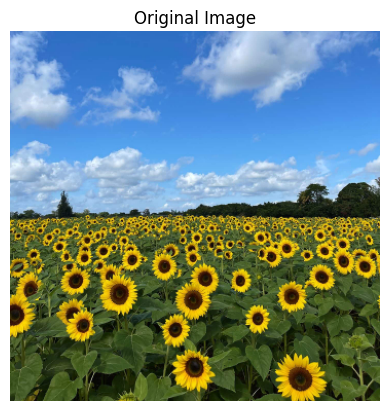

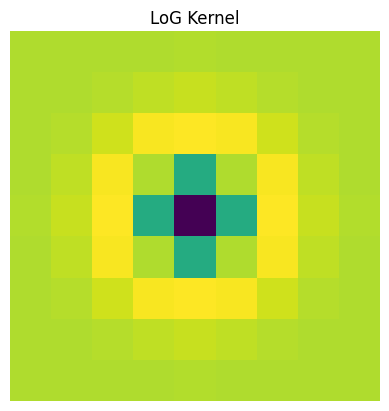

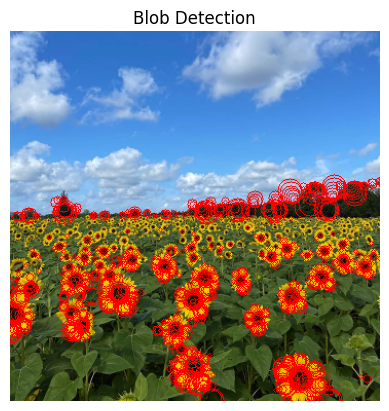

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the input image
input_image_path = r"C:\Users\Nipun Pushpakumara\Desktop\LECTURES\coding\A02\Assignment 02\the_berry_farms_sunflower_field.jpeg"
input_image = cv.imread(input_image_path, cv.IMREAD_REDUCED_COLOR_4)
input_image_rgb = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)

# Plot the original image
plt.imshow(input_image_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Define the Laplacian of Gaussian (LoG) kernel
def create_log_kernel(sigma, size):
    if size % 2 == 0:
        size += 1
    sigma_squared = sigma ** 2
    idx_range = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    x_idx, y_idx = np.meshgrid(idx_range, idx_range)
    tmp_calculation = -(np.square(x_idx) + np.square(y_idx)) / (2. * sigma_squared)
    kernel = np.exp(tmp_calculation)
    kernel[kernel < np.finfo(float).eps * np.amax(kernel)] = 0
    kernel_sum = np.sum(kernel)
    if kernel_sum != 0:
        kernel /= np.sum(kernel)
    tmp_kernel = np.multiply(kernel, np.square(x_idx) + np.square(y_idx) - 2 * sigma_squared) / (sigma_squared ** 2)
    kernel = tmp_kernel - np.sum(tmp_kernel) / (size ** 2)
    return kernel

# Blob detection
def detect_blobs(image, sigma_scales, threshold):
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    gray_image = np.float32(gray_image)
    cv.normalize(gray_image, gray_image, 1, 0, cv.NORM_MINMAX)

    sigma_0 = np.sqrt(2)
    k = np.sqrt(2)
    num_scales = sigma_scales
    sigmas = sigma_0 * np.power(k, np.arange(num_scales))
    sigmas = [sigma_scales] * num_scales

    # Apply LoG kernel filtering with scaled kernel size and sigma
    image_stack = None
    for i in range(num_scales):
        size = int(2 * np.ceil(4 * sigmas[i]) + 1)
        # with Laplacian response normalization
        kernel = create_log_kernel(sigmas[i], size) * np.power(sigmas[i], 2)
        filtered_image = cv.filter2D(gray_image, cv.CV_32F, kernel)
        filtered_image = pow(filtered_image, 2)
        if i == 0:
            image_stack = filtered_image
        else:
            image_stack = np.dstack((image_stack, filtered_image))

    # Maximum response extraction
    scale_space = None
    for i in range(num_scales):
        filtered_image = cv.dilate(image_stack[:, :, i], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT)
        if i == 0:
            scale_space = filtered_image
        else:
            scale_space = np.dstack((scale_space, filtered_image))
    max_stack = np.amax(scale_space, axis=2)
    max_stack = np.repeat(max_stack[:, :, np.newaxis], num_scales, axis=2)
    max_stack = np.multiply((max_stack == scale_space), scale_space)

    radius_vector = None
    x_vector = None
    y_vector = None
    for i in range(num_scales):
        radius = np.sqrt(2) * sigmas[i]
        threshold = threshold
        # Filter out redundant response
        valid = (max_stack[:, :, i] == image_stack[:, :, i]) * image_stack[:, :, i]
        valid[valid <= threshold] = 0
        (x, y) = np.nonzero(valid)
        if i == 1:
            x_vector = x
            y_vector = y
            radius_vector = np.repeat(radius, np.size(x))
        else:
            x_vector = np.concatenate((x_vector, x), axis=None)
            y_vector = np.concatenate((y_vector, y), axis=None)
            tmp_vector = np.repeat(radius, np.size(x))
            radius_vector = np.concatenate((radius_vector, tmp_vector), axis=None)

    return x_vector, y_vector, radius_vector

# Detect blobs in the input image for multiple sigma scales
input_image = cv.imread(r"C:\Users\Nipun Pushpakumara\Desktop\LECTURES\coding\A02\Assignment 02\the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)
x_coordinates_all = []
y_coordinates_all = []
radii_all = []
for sigma_scale in range(2, 10):
    x_coords, y_coords, radii = detect_blobs(input_image, sigma_scale, 0.03)
    x_coordinates_all.append(x_coords)
    y_coordinates_all.append(y_coords)
    radii_all.append(radii)

x_coordinates_all = np.concatenate(x_coordinates_all, axis=None)
y_coordinates_all = np.concatenate(y_coordinates_all, axis=None)
radii_all = np.concatenate(radii_all, axis=None)

# Draw circles around detected blobs on the input image
output_image = input_image.copy()
for i in range(int(len(x_coordinates_all))):
    cv.circle(output_image, (y_coordinates_all[i], x_coordinates_all[i]), int(radii_all[i]), (0, 0, 255), 1)

# plot the log kernel
log_kernel = create_log_kernel(1, 9)
plt.imshow(log_kernel)
plt.title('LoG Kernel')
plt.axis('off')
plt.show()

# Display the image with detected blobs
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
plt.title("Blob Detection")
plt.axis('off')
plt.show()

